# Comprehensive AudioMAE++ Notebook
# Dataset Preparation & Model Training Pipeline

This notebook provides a complete end-to-end pipeline for:
1. **Dataset Preparation**: Download, preprocess, and prepare ESC-50 audio data
2. **Spectrogram Generation**: Convert audio to mel spectrograms and save for faster training
3. **Model Architecture**: Implement AudioMAE++ with Macaron blocks, SwiGLU, and RoPE
4. **Pre-training**: Train the masked autoencoder with enhanced loss functions
5. **Fine-tuning**: Classification fine-tuning on ESC-50 labels
6. **Evaluation**: Visualize reconstructions and measure classification accuracy

## Architecture Overview
```
Audio → Mel Spectrogram → Patches → Mask 75% → Encoder → Decoder → Reconstruct
                                       ↓
                              Embedding → Contrastive Loss + Uniformity Loss
```

**AudioMAE++ Features**:
- Macaron-style transformer blocks (FFN-Attention-FFN sandwich)
- SwiGLU activation (gated linear units with Swish)
- Rotary Position Embeddings (RoPE)
- Asymmetric encoder-decoder design
- 75% masking ratio for self-supervised learning

**Enhanced Training for Better Semantic Embeddings**:
- **Contrastive Loss (InfoNCE)**: Encourages same-class samples to have similar embeddings
- **Uniformity Loss**: Prevents embedding collapse by spreading embeddings uniformly
- **Mean Pooling**: Better embedding extraction than CLS token alone
- **Configurable**: All new features can be enabled/disabled via Config class

---
## Part 1: Setup and Configuration
---

### 1.1 Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
from pathlib import Path
import os
import csv
import zipfile
import requests
from tqdm.auto import tqdm
from einops import rearrange
import math
import random
from datetime import datetime
import mlflow
import mlflow.pytorch

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1.2 Configuration

In [ ]:
class Config:
    # Audio processing
    sample_rate = 22050
    n_mels = 128
    n_fft = 2048
    hop_length = 512
    audio_duration = 5  # seconds
    
    # Spectrogram image size
    img_size = 224
    
    # Patch settings
    patch_size = 16
    num_patches = (img_size // patch_size) ** 2  # 196 patches
    
    # Model architecture
    embed_dim = 768
    encoder_depth = 12
    encoder_heads = 12
    decoder_embed_dim = 512
    decoder_depth = 8
    decoder_heads = 16
    mlp_ratio = 4.0
    
    # Training
    mask_ratio = 0.75  # Mask 75% of patches (lower for better semantic embeddings)
    batch_size = 16
    learning_rate = 1.5e-4
    weight_decay = 0.05
    epochs = 50
    warmup_epochs = 5
    
    # AudioMAE++ features
    use_macaron = True
    use_swiglu = True
    use_rope = True
    
    # Embedding extraction
    pooling_mode = "mean"  # "cls", "mean", or "cls+mean"
    
    # Contrastive loss (improves semantic clustering)
    use_contrastive_loss = True
    contrastive_weight = 0.01  # Weight for contrastive loss
    contrastive_temperature = 0.07  # Temperature for InfoNCE
    
    # Uniformity loss (prevents embedding collapse)
    use_uniformity_loss = True
    uniformity_weight = 0.1  # Weight for uniformity loss
    uniformity_t = 2.0  # Temperature parameter for uniformity
    
    def get_experiment_name(self):
        """Generate a unique experiment name based on config parameters."""
        features = []
        if self.use_macaron:
            features.append("macaron")
        if self.use_swiglu:
            features.append("swiglu")
        if self.use_rope:
            features.append("rope")
        if self.use_contrastive_loss:
            features.append("contrast")
        if self.use_uniformity_loss:
            features.append("uniform")
        
        feature_str = "-".join(features) if features else "baseline"
        
        name = (f"audiomae_"
                f"d{self.encoder_depth}_"
                f"e{self.embed_dim}_"
                f"m{int(self.mask_ratio*100)}_"
                f"{feature_str}")
        return name
    
    def get_experiment_dir(self, base_dir="experiments"):
        """Create and return experiment directory path."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        exp_name = self.get_experiment_name()
        exp_dir = Path(base_dir) / f"{exp_name}_{timestamp}"
        exp_dir.mkdir(parents=True, exist_ok=True)
        
        # Create subdirectories
        (exp_dir / "checkpoints").mkdir(exist_ok=True)
        (exp_dir / "logs").mkdir(exist_ok=True)
        (exp_dir / "visualizations").mkdir(exist_ok=True)
        
        return exp_dir

config = Config()
print(f"Configuration loaded:")
print(f"  Number of patches: {config.num_patches}")
print(f"  Patches per side: {config.img_size // config.patch_size}")
print(f"  Mask ratio: {config.mask_ratio}")
print(f"  Macaron blocks: {config.use_macaron}")
print(f"  SwiGLU: {config.use_swiglu}")
print(f"  RoPE: {config.use_rope}")
print(f"  Pooling mode: {config.pooling_mode}")
print(f"  Contrastive loss: {config.use_contrastive_loss} (weight={config.contrastive_weight})")
print(f"  Uniformity loss: {config.use_uniformity_loss} (weight={config.uniformity_weight})")
print(f"\nExperiment name: {config.get_experiment_name()}")

---
## Part 2: Dataset Preparation
---

### 2.1 Download ESC-50 Dataset

In [4]:
def download_file(url, dest_path):
    """Download a file with progress bar."""
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(dest_path, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=dest_path.name) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))

def setup_esc50(data_dir="./data"):
    """Download and extract ESC-50 dataset."""
    data_dir = Path(data_dir)
    esc50_dir = data_dir / "ESC-50-master"
    
    if esc50_dir.exists():
        print("ESC-50 already downloaded")
        return esc50_dir
    
    data_dir.mkdir(exist_ok=True)
    zip_path = data_dir / "esc50.zip"
    
    print("Downloading ESC-50...")
    url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
    download_file(url, zip_path)
    
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    
    zip_path.unlink()  # Remove zip file
    print(f"ESC-50 ready at {esc50_dir}")
    return esc50_dir

In [5]:
# Download the dataset
esc50_path = setup_esc50()
print(f"\nESC-50 path: {esc50_path}")
print(f"Audio files: {len(list((esc50_path / 'audio').glob('*.wav')))}")

esc50.zip: 0.00B [00:00, ?B/s]

Extracting...
ESC-50 ready at data/ESC-50-master

ESC-50 path: data/ESC-50-master
Audio files: 2000


### 2.2 Audio to Spectrogram Conversion

In [6]:
class AudioToSpectrogram:
    """Convert audio waveform to mel spectrogram image."""
    
    def __init__(self, config):
        self.config = config
        self.target_length = config.sample_rate * config.audio_duration
        
    def __call__(self, waveform, sr):
        # Resample if necessary
        if sr != self.config.sample_rate:
            waveform = librosa.resample(waveform, orig_sr=sr, target_sr=self.config.sample_rate)
        
        # Ensure mono
        if len(waveform.shape) > 1:
            waveform = waveform.mean(axis=0)
        
        # Pad or truncate to target length
        if len(waveform) < self.target_length:
            # Pad with zeros
            waveform = np.pad(waveform, (0, self.target_length - len(waveform)))
        else:
            # Random crop
            start = np.random.randint(0, len(waveform) - self.target_length + 1)
            waveform = waveform[start:start + self.target_length]
        
        # Compute mel spectrogram
        mel = librosa.feature.melspectrogram(
            y=waveform,
            sr=self.config.sample_rate,
            n_mels=self.config.n_mels,
            n_fft=self.config.n_fft,
            hop_length=self.config.hop_length
        )
        
        # Convert to dB scale
        mel_db = librosa.power_to_db(mel, ref=np.max)
        
        # Normalize to [0, 1]
        mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-8)
        
        # Resize to target size
        mel_img = Image.fromarray((mel_norm * 255).astype(np.uint8))
        mel_img = mel_img.resize((self.config.img_size, self.config.img_size), Image.BILINEAR)
        
        # Convert to tensor and add channel dimension (grayscale → 3 channels for ViT compatibility)
        mel_tensor = torch.tensor(np.array(mel_img), dtype=torch.float32) / 255.0
        mel_tensor = mel_tensor.unsqueeze(0).repeat(3, 1, 1)  # [3, H, W]
        
        # Normalize with ImageNet stats (for transfer learning compatibility)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        mel_tensor = (mel_tensor - mean) / std
        
        return mel_tensor

### 2.3 Precompute and Save Spectrograms

Pre-computing spectrograms and saving them to disk significantly speeds up training.
This step processes all 2000 ESC-50 audio files and saves them as .npy files.

In [7]:
# Create output directories
output_dir = Path('data/imgs')
preview_dir = output_dir / 'pre'
full_dir = output_dir / 'full'
sound_dir = Path('data/ESC-50-master/audio')

os.makedirs(output_dir, exist_ok=True)
os.makedirs(preview_dir, exist_ok=True)
os.makedirs(full_dir, exist_ok=True)

# Initialize transform
transform = AudioToSpectrogram(config)

# Process all audio files
print("Precomputing spectrograms for all audio files...")
audio_files = list(sound_dir.glob('*.wav'))

for audio_path in tqdm(audio_files, desc="Processing audio"):
    # Load audio
    waveform, sr = librosa.load(audio_path, sr=None)
    
    # Convert to spectrogram
    spectrogram = transform(waveform, sr)
    
    # Save full spectrogram as .npy for fast loading
    np.save(full_dir / f"{audio_path.stem}.npy", spectrogram.numpy())
    
    # Save preview as .png for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    spec_vis = (spectrogram * std + mean).numpy()[0]  # Take first channel
    plt.imsave(preview_dir / f"{audio_path.stem}.png", spec_vis, cmap='magma')

print(f"\nPrecomputed spectrograms saved to:")
print(f"  Full: {full_dir}")
print(f"  Preview: {preview_dir}")

Precomputing spectrograms for all audio files...


Processing audio:   0%|          | 0/2000 [00:00<?, ?it/s]


Precomputed spectrograms saved to:
  Full: data/imgs/full
  Preview: data/imgs/pre


### 2.4 Dataset Classes

In [8]:
class ESC50Dataset(Dataset):
    """ESC-50 Environmental Sound Classification dataset."""
    
    def __init__(self, root_dir, config, fold=None, train=True, use_precomputed=True, precomputed_dir='data/imgs/full'):
        self.root_dir = Path(root_dir)
        self.audio_dir = self.root_dir / "audio"
        self.config = config
        self.use_precomputed = use_precomputed
        self.precomputed_dir = Path(precomputed_dir)
        
        if not use_precomputed:
            self.transform = AudioToSpectrogram(config)
        
        # Load metadata
        meta_path = self.root_dir / "meta" / "esc50.csv"
        
        self.samples = []
        self.labels = []
        self.class_names = {}
        
        with open(meta_path, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                file_fold = int(row['fold'])
                
                # Use fold for train/val split
                if fold is not None:
                    if train and file_fold == fold:
                        continue  # Skip validation fold
                    elif not train and file_fold != fold:
                        continue  # Only use validation fold
                
                self.samples.append(row['filename'])
                self.labels.append(int(row['target']))
                self.class_names[int(row['target'])] = row['category']
        
        print(f"ESC-50 {'train' if train else 'val'}: {len(self.samples)} samples, {len(self.class_names)} classes")
        print(f"Using {'precomputed' if use_precomputed else 'on-the-fly'} spectrograms")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        filename = self.samples[idx]
        label = self.labels[idx]
        
        if self.use_precomputed:
            # Load precomputed spectrogram from .npy file
            npy_path = self.precomputed_dir / f"{Path(filename).stem}.npy"
            spectrogram = torch.from_numpy(np.load(npy_path))
        else:
            # Load audio and compute spectrogram on-the-fly
            audio_path = self.audio_dir / filename
            waveform, sr = librosa.load(audio_path, sr=None)
            spectrogram = self.transform(waveform, sr)
        
        return spectrogram, label


class CombinedAudioDataset(Dataset):
    """Combine multiple audio datasets for pre-training (ignores labels)."""
    
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.cumulative_lengths = np.cumsum([0] + self.lengths)
    
    def __len__(self):
        return sum(self.lengths)
    
    def __getitem__(self, idx):
        # Find which dataset this index belongs to
        for i, (start, end) in enumerate(zip(self.cumulative_lengths[:-1], self.cumulative_lengths[1:])):
            if start <= idx < end:
                local_idx = idx - start
                spectrogram, _ = self.datasets[i][local_idx]  # Ignore label for MAE pretraining
                return spectrogram
        raise IndexError(f"Index {idx} out of range")

### 2.5 Test Dataset and Visualize Sample

ESC-50 train: 1600 samples, 50 classes
Using precomputed spectrograms
ESC-50 val: 400 samples, 50 classes
Using precomputed spectrograms

Spectrogram shape: torch.Size([3, 224, 224])
Label: 25 (footsteps)


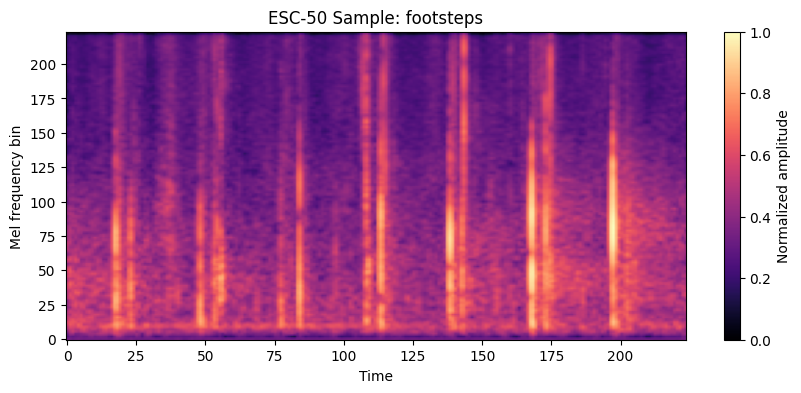

In [9]:
# Create datasets (using precomputed spectrograms)
esc50_train = ESC50Dataset(esc50_path, config, fold=5, train=True, use_precomputed=True)
esc50_val = ESC50Dataset(esc50_path, config, fold=5, train=False, use_precomputed=True)

# Visualize a sample
spec, label = esc50_train[44]
print(f"\nSpectrogram shape: {spec.shape}")
print(f"Label: {label} ({esc50_train.class_names[label]})")

# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
spec_vis = (spec * std + mean)[0].numpy()  # Take first channel

plt.figure(figsize=(10, 4))
plt.imshow(spec_vis, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label='Normalized amplitude')
plt.title(f"ESC-50 Sample: {esc50_train.class_names[label]}")
plt.xlabel('Time')
plt.ylabel('Mel frequency bin')
plt.show()

---
## Part 3: Model Architecture
---

### 3.1 Core Components: SwiGLU and Standard FFN

In [10]:
class SwiGLU(nn.Module):
    """SwiGLU activation: Swish(x @ W_gate) * (x @ W_value)"""
    
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.w_gate = nn.Linear(dim, hidden_dim, bias=False)
        self.w_value = nn.Linear(dim, hidden_dim, bias=False)
        self.w_out = nn.Linear(hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        gate = F.silu(self.w_gate(x))  # Swish activation
        value = self.w_value(x)
        x = gate * value  # Element-wise gating
        x = self.dropout(x)
        x = self.w_out(x)
        return x


class StandardFFN(nn.Module):
    """Standard FFN with GELU activation."""
    
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

In [ ]:
# Loss functions for improved semantic embeddings

def info_nce_loss(embeddings, labels, temperature=0.07):
    """
    InfoNCE contrastive loss for same-class positive pairs.
    
    This loss encourages embeddings of samples with the same label to be close
    together while pushing embeddings of different classes apart.
    
    Args:
        embeddings: [B, D] tensor of normalized embeddings
        labels: [B] tensor of class labels
        temperature: Temperature parameter for scaling similarities
    
    Returns:
        Scalar loss value
    """
    embeddings = F.normalize(embeddings, dim=1)
    batch_size = embeddings.shape[0]
    
    # Compute similarity matrix
    sim_matrix = torch.matmul(embeddings, embeddings.T) / temperature
    
    # Create positive pair mask (same label, excluding self)
    labels = labels.view(-1, 1)
    pos_mask = (labels == labels.T).float()
    pos_mask.fill_diagonal_(0)
    
    # Check if there are any positive pairs
    num_positives = pos_mask.sum(dim=1)
    if num_positives.sum() == 0:
        return torch.tensor(0.0, device=embeddings.device, requires_grad=True)
    
    # For numerical stability
    logits_max, _ = sim_matrix.max(dim=1, keepdim=True)
    logits = sim_matrix - logits_max.detach()
    
    # Mask out self-similarities
    logits_mask = torch.ones_like(sim_matrix)
    logits_mask.fill_diagonal_(0)
    
    # Compute log probabilities
    exp_logits = torch.exp(logits) * logits_mask
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-8)
    
    # Mean log-likelihood over positive pairs
    mask_pos_pairs = pos_mask * logits_mask
    num_pos_per_sample = mask_pos_pairs.sum(dim=1)
    
    # Only compute loss for samples with positive pairs
    mean_log_prob_pos = (mask_pos_pairs * log_prob).sum(dim=1)
    mean_log_prob_pos = mean_log_prob_pos / (num_pos_per_sample + 1e-8)
    
    # Average over samples with positive pairs
    valid_samples = num_pos_per_sample > 0
    if valid_samples.sum() == 0:
        return torch.tensor(0.0, device=embeddings.device, requires_grad=True)
    
    loss = -mean_log_prob_pos[valid_samples].mean()
    return loss


def uniformity_loss(embeddings, t=2.0):
    """
    Uniformity loss to encourage embeddings to be uniformly distributed on the unit hypersphere.
    
    This prevents the embedding space from collapsing to a small region.
    From "Understanding Contrastive Representation Learning" (Wang & Isola, 2020).
    
    Args:
        embeddings: [B, D] tensor of embeddings
        t: Temperature parameter (default: 2.0)
    
    Returns:
        Scalar uniformity loss (lower is more uniform)
    """
    embeddings = F.normalize(embeddings, dim=1)
    sq_pdist = torch.pdist(embeddings, p=2).pow(2)
    loss = sq_pdist.mul(-t).exp().mean().log()
    return loss


def get_embedding(latent, mode="mean"):
    """
    Extract embedding from encoder output with configurable pooling.
    
    Args:
        latent: [B, N+1, D] encoder output (includes CLS token at position 0)
        mode: Pooling mode - "cls", "mean", or "cls+mean"
    
    Returns:
        [B, D] or [B, 2*D] embedding tensor
    """
    if mode == "cls":
        return latent[:, 0, :]
    elif mode == "mean":
        return latent[:, 1:, :].mean(dim=1)  # Average over patch tokens (excluding CLS)
    elif mode == "cls+mean":
        cls_emb = latent[:, 0, :]
        mean_emb = latent[:, 1:, :].mean(dim=1)
        return torch.cat([cls_emb, mean_emb], dim=1)
    else:
        raise ValueError(f"Unknown pooling mode: {mode}")

### 3.2 Rotary Position Embeddings (RoPE)

In [11]:
class RotaryPositionEmbedding(nn.Module):
    """Rotary Position Embedding for 2D (image patches)."""
    
    def __init__(self, dim, max_seq_len=256):
        super().__init__()
        self.dim = dim
        
        # Compute frequency bands
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        
        # Precompute position encodings
        t = torch.arange(max_seq_len).float()
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())
    
    def forward(self, x, seq_len=None):
        if seq_len is None:
            seq_len = x.shape[1]
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]


def rotate_half(x):
    """Rotate half the hidden dims of the input."""
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat([-x2, x1], dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin):
    """Apply rotary position embedding to queries and keys."""
    cos = cos.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, dim]
    sin = sin.unsqueeze(0).unsqueeze(2)
    
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

### 3.3 Multi-Head Attention with RoPE

In [12]:
class Attention(nn.Module):
    """Multi-head attention with optional RoPE."""
    
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0, use_rope=False, max_seq_len=256):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.use_rope = use_rope
        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
        
        if use_rope:
            self.rope = RotaryPositionEmbedding(dim_head, max_seq_len)
    
    def forward(self, x):
        b, n, _ = x.shape
        
        # Compute Q, K, V
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b n h d', h=self.heads), qkv)
        
        # Apply RoPE if enabled
        if self.use_rope:
            cos, sin = self.rope(x, seq_len=n)
            q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Attention
        q = rearrange(q, 'b n h d -> b h n d')
        k = rearrange(k, 'b n h d -> b h n d')
        v = rearrange(v, 'b n h d -> b h n d')
        
        attn = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

### 3.4 Transformer Blocks: Standard vs Macaron

In [13]:
class StandardTransformerBlock(nn.Module):
    """Standard transformer block: Attention -> FFN"""
    
    def __init__(self, dim, heads, dim_head, mlp_ratio=4.0, dropout=0.0, 
                 use_swiglu=False, use_rope=False, max_seq_len=256):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dim_head, dropout, use_rope, max_seq_len)
        self.norm2 = nn.LayerNorm(dim)
        
        hidden_dim = int(dim * mlp_ratio)
        if use_swiglu:
            self.ffn = SwiGLU(dim, hidden_dim, dropout)
        else:
            self.ffn = StandardFFN(dim, hidden_dim, dropout)
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x


class MacaronTransformerBlock(nn.Module):
    """
    Macaron-style transformer block (AudioMAE++):
    FFN (½) -> Attention -> FFN with SwiGLU (½)
    
    The attention is sandwiched between two FFN layers,
    each with half the residual weight.
    """
    
    def __init__(self, dim, heads, dim_head, mlp_ratio=4.0, dropout=0.0,
                 use_swiglu=True, use_rope=False, max_seq_len=256):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        
        # First FFN (simple, half-weighted)
        self.norm1 = nn.LayerNorm(dim)
        self.ffn1 = StandardFFN(dim, hidden_dim, dropout)
        
        # Attention
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dim_head, dropout, use_rope, max_seq_len)
        
        # Second FFN with SwiGLU (half-weighted)
        self.norm3 = nn.LayerNorm(dim)
        if use_swiglu:
            self.ffn2 = SwiGLU(dim, hidden_dim, dropout)
        else:
            self.ffn2 = StandardFFN(dim, hidden_dim, dropout)
        
        # Half-weight factor for FFN residuals
        self.ffn_scale = 0.5
    
    def forward(self, x):
        # First FFN (half-weighted)
        x = x + self.ffn_scale * self.ffn1(self.norm1(x))
        
        # Attention (full weight)
        x = x + self.attn(self.norm2(x))
        
        # Second FFN with SwiGLU (half-weighted)
        x = x + self.ffn_scale * self.ffn2(self.norm3(x))
        
        return x

### 3.5 Patch Embedding

In [14]:
class PatchEmbed(nn.Module):
    """Convert image to patch embeddings."""
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x: [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.proj(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

### 3.6 AudioMAE++ Full Model

In [ ]:
class AudioMAEPlusPlus(nn.Module):
    """
    AudioMAE++ - Masked Autoencoder with:
    - Macaron-style transformer blocks
    - SwiGLU activation
    - Optional RoPE
    - Contrastive and uniformity losses for better semantic embeddings
    """
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=config.img_size,
            patch_size=config.patch_size,
            in_chans=3,
            embed_dim=config.embed_dim
        )
        num_patches = self.patch_embed.num_patches
        
        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))
        
        # Position embeddings (if not using RoPE)
        if not config.use_rope:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config.embed_dim))
        else:
            self.pos_embed = None
        
        # Mask token
        self.mask_token = nn.Parameter(torch.zeros(1, 1, config.decoder_embed_dim))
        
        # Select transformer block type
        BlockClass = MacaronTransformerBlock if config.use_macaron else StandardTransformerBlock
        
        # Encoder
        dim_head = config.embed_dim // config.encoder_heads
        self.encoder_blocks = nn.ModuleList([
            BlockClass(
                dim=config.embed_dim,
                heads=config.encoder_heads,
                dim_head=dim_head,
                mlp_ratio=config.mlp_ratio,
                use_swiglu=config.use_swiglu,
                use_rope=config.use_rope,
                max_seq_len=num_patches + 1
            )
            for _ in range(config.encoder_depth)
        ])
        self.encoder_norm = nn.LayerNorm(config.embed_dim)
        
        # Encoder to decoder projection
        self.encoder_to_decoder = nn.Linear(config.embed_dim, config.decoder_embed_dim, bias=True)
        
        # Decoder position embeddings
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config.decoder_embed_dim))
        
        # Decoder
        decoder_dim_head = config.decoder_embed_dim // config.decoder_heads
        self.decoder_blocks = nn.ModuleList([
            BlockClass(
                dim=config.decoder_embed_dim,
                heads=config.decoder_heads,
                dim_head=decoder_dim_head,
                mlp_ratio=config.mlp_ratio,
                use_swiglu=config.use_swiglu,
                use_rope=config.use_rope,
                max_seq_len=num_patches + 1
            )
            for _ in range(config.decoder_depth)
        ])
        self.decoder_norm = nn.LayerNorm(config.decoder_embed_dim)
        
        # Prediction head (reconstruct patches)
        self.pred_head = nn.Linear(
            config.decoder_embed_dim,
            config.patch_size ** 2 * 3,  # Reconstruct RGB patches
            bias=True
        )
        
        self.initialize_weights()
    
    def initialize_weights(self):
        # Initialize position embeddings
        if self.pos_embed is not None:
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)
        
        # Initialize tokens
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.mask_token, std=0.02)
        
        # Initialize linear layers
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
    
    def random_masking(self, x, mask_ratio):
        """
        Perform random masking by shuffling.
        x: [B, N, D] (patches)
        Returns: masked x, mask, ids_restore
        """
        B, N, D = x.shape
        len_keep = int(N * (1 - mask_ratio))
        
        # Random noise for shuffling
        noise = torch.rand(B, N, device=x.device)
        
        # Sort noise to get shuffle indices
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # Keep only unmasked tokens
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, D))
        
        # Generate binary mask: 0 = keep, 1 = masked
        mask = torch.ones(B, N, device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        
        return x_masked, mask, ids_restore
    
    def forward_encoder(self, x, mask_ratio):
        """Encode only unmasked patches."""
        # Patch embedding
        x = self.patch_embed(x)  # [B, N, D]
        
        # Add position embeddings (before masking)
        if self.pos_embed is not None:
            x = x + self.pos_embed[:, 1:, :]  # Skip CLS position
        
        # Random masking
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        
        # Append CLS token
        cls_token = self.cls_token
        if self.pos_embed is not None:
            cls_token = cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Encoder blocks
        for block in self.encoder_blocks:
            x = block(x)
        x = self.encoder_norm(x)
        
        return x, mask, ids_restore
    
    def forward_decoder(self, x, ids_restore):
        """Decode and reconstruct masked patches."""
        # Project to decoder dimension
        x = self.encoder_to_decoder(x)
        
        # Append mask tokens
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # Skip CLS, add masks
        
        # Unshuffle to restore original order
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).expand(-1, -1, x.shape[2]))
        
        # Add back CLS token
        x = torch.cat([x[:, :1, :], x_], dim=1)
        
        # Add decoder position embeddings
        x = x + self.decoder_pos_embed
        
        # Decoder blocks
        for block in self.decoder_blocks:
            x = block(x)
        x = self.decoder_norm(x)
        
        # Predict patches (skip CLS)
        x = self.pred_head(x[:, 1:, :])
        
        return x
    
    def forward_loss(self, imgs, pred, mask):
        """
        Compute MSE loss on masked patches only.
        imgs: [B, 3, H, W]
        pred: [B, N, patch_size^2 * 3]
        mask: [B, N] (1 = masked, 0 = visible)
        """
        # Patchify target images
        target = self.patchify(imgs)
        
        # Normalize target (per-patch)
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)
        target = (target - mean) / (var + 1e-6).sqrt()
        
        # MSE loss on masked patches only
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # Mean over patch pixels
        loss = (loss * mask).sum() / mask.sum()  # Mean over masked patches
        
        return loss
    
    def patchify(self, imgs):
        """Convert images to patches."""
        p = self.config.patch_size
        h = w = self.config.img_size // p
        
        x = imgs.reshape(imgs.shape[0], 3, h, p, w, p)
        x = x.permute(0, 2, 4, 3, 5, 1)  # [B, h, w, p, p, 3]
        x = x.reshape(imgs.shape[0], h * w, p * p * 3)
        return x
    
    def unpatchify(self, x):
        """Convert patches back to images."""
        p = self.config.patch_size
        h = w = self.config.img_size // p
        
        x = x.reshape(x.shape[0], h, w, p, p, 3)
        x = x.permute(0, 5, 1, 3, 2, 4)  # [B, 3, h, p, w, p]
        x = x.reshape(x.shape[0], 3, h * p, w * p)
        return x
    
    def get_embedding(self, imgs, mask_ratio=0.0):
        """
        Extract embedding for inference (no masking by default).
        
        Args:
            imgs: [B, 3, H, W] input images
            mask_ratio: Masking ratio (default 0 for inference)
        
        Returns:
            [B, D] embedding tensor using configured pooling mode
        """
        # Encode without masking for embedding extraction
        latent, _, _ = self.forward_encoder(imgs, mask_ratio)
        
        # Apply configured pooling
        embedding = get_embedding(latent, mode=self.config.pooling_mode)
        
        return embedding
    
    def forward(self, imgs, mask_ratio=None, labels=None):
        """
        Full forward pass with optional contrastive and uniformity losses.
        
        Args:
            imgs: [B, 3, H, W] input spectrograms
            mask_ratio: Override config mask ratio if provided
            labels: [B] class labels for contrastive loss (optional)
        
        Returns:
            If labels provided and losses enabled:
                (total_loss, pred, mask, loss_dict)
            Otherwise:
                (loss, pred, mask)
        """
        if mask_ratio is None:
            mask_ratio = self.config.mask_ratio
        
        # Encode
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        
        # Decode
        pred = self.forward_decoder(latent, ids_restore)
        
        # Reconstruction loss
        recon_loss = self.forward_loss(imgs, pred, mask)
        
        # Check if we should compute additional losses
        use_contrastive = self.config.use_contrastive_loss and labels is not None
        use_uniformity = self.config.use_uniformity_loss and labels is not None
        
        if use_contrastive or use_uniformity:
            # Get embeddings for additional losses
            embedding = get_embedding(latent, mode=self.config.pooling_mode)
            
            # Initialize losses
            c_loss = torch.tensor(0.0, device=imgs.device)
            u_loss = torch.tensor(0.0, device=imgs.device)
            
            # Contrastive loss
            if use_contrastive:
                c_loss = info_nce_loss(
                    embedding, 
                    labels, 
                    temperature=self.config.contrastive_temperature
                )
            
            # Uniformity loss
            if use_uniformity:
                u_loss = uniformity_loss(embedding, t=self.config.uniformity_t)
            
            # Total loss
            total_loss = (
                recon_loss + 
                self.config.contrastive_weight * c_loss + 
                self.config.uniformity_weight * u_loss
            )
            
            # Loss dictionary for logging
            loss_dict = {
                'total': total_loss.item(),
                'reconstruction': recon_loss.item(),
                'contrastive': c_loss.item(),
                'uniformity': u_loss.item()
            }
            
            return total_loss, pred, mask, loss_dict
        
        # Standard return for backward compatibility
        return recon_loss, pred, mask

### 3.7 Create and Test Model

In [16]:
# Create model
model = AudioMAEPlusPlus(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created successfully!")
print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")
print(f"\nModel config:")
print(f"  - Encoder: {config.encoder_depth} layers, {config.embed_dim} dim, {config.encoder_heads} heads")
print(f"  - Decoder: {config.decoder_depth} layers, {config.decoder_embed_dim} dim, {config.decoder_heads} heads")
print(f"  - Macaron blocks: {config.use_macaron}")
print(f"  - SwiGLU FFN: {config.use_swiglu}")
print(f"  - RoPE: {config.use_rope}")
print(f"  - Mask ratio: {config.mask_ratio}")

# Test forward pass
print(f"\nTesting forward pass...")
dummy_input = torch.randn(16, 3, config.img_size, config.img_size).to(device)
loss, pred, mask = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Prediction shape: {pred.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Loss: {loss.item():.4f}")
print(f"Masked patches: {mask[0].sum().item()}/{mask.shape[1]} ({mask[0].mean().item()*100:.1f}%)")
print(f"\nModel test passed!")


Model created successfully!
Total parameters: 221.84M
Trainable parameters: 221.84M

Model config:
  - Encoder: 12 layers, 768 dim, 12 heads
  - Decoder: 8 layers, 512 dim, 16 heads
  - Macaron blocks: True
  - SwiGLU FFN: True
  - RoPE: True
  - Mask ratio: 0.85

Testing forward pass...
Input shape: torch.Size([16, 3, 224, 224])
Prediction shape: torch.Size([16, 196, 768])
Mask shape: torch.Size([16, 196])
Loss: 1.2001
Masked patches: 167.0/196 (85.2%)

Model test passed!


---
## Part 4: Pre-training (Masked Autoencoding)
---

### 4.1 Training Utilities

In [ ]:
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Cosine learning rate schedule with warmup."""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_epoch(model, dataloader, optimizer, scheduler, device, use_labels=True):
    """
    Train for one epoch with optional contrastive and uniformity losses.
    
    Args:
        model: AudioMAEPlusPlus model
        dataloader: Training data loader
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to use
        use_labels: Whether to pass labels for contrastive/uniformity losses
    
    Returns:
        Dictionary with average losses for the epoch
    """
    model.train()
    total_losses = {'total': 0, 'reconstruction': 0, 'contrastive': 0, 'uniformity': 0}
    num_batches = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        if isinstance(batch, (list, tuple)):
            imgs, labels = batch[0].to(device), batch[1].to(device)
        else:
            imgs = batch.to(device)
            labels = None
        
        optimizer.zero_grad()
        
        # Forward pass with or without labels
        if use_labels and labels is not None and (model.config.use_contrastive_loss or model.config.use_uniformity_loss):
            loss, _, _, loss_dict = model(imgs, labels=labels)
            
            # Accumulate losses
            for key in total_losses:
                total_losses[key] += loss_dict[key]
            
            pbar.set_postfix({
                "loss": f"{loss_dict['total']:.4f}",
                "recon": f"{loss_dict['reconstruction']:.4f}",
                "contr": f"{loss_dict['contrastive']:.4f}",
                "unif": f"{loss_dict['uniformity']:.4f}",
                "lr": f"{scheduler.get_last_lr()[0]:.2e}"
            })
        else:
            loss, _, _ = model(imgs)
            total_losses['total'] += loss.item()
            total_losses['reconstruction'] += loss.item()
            
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "lr": f"{scheduler.get_last_lr()[0]:.2e}"})
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        num_batches += 1
    
    # Average losses
    avg_losses = {key: val / num_batches for key, val in total_losses.items()}
    return avg_losses


@torch.no_grad()
def validate(model, dataloader, device, use_labels=True):
    """
    Validate model with optional contrastive and uniformity losses.
    
    Args:
        model: AudioMAEPlusPlus model
        dataloader: Validation data loader
        device: Device to use
        use_labels: Whether to pass labels for contrastive/uniformity losses
    
    Returns:
        Dictionary with average losses
    """
    model.eval()
    total_losses = {'total': 0, 'reconstruction': 0, 'contrastive': 0, 'uniformity': 0}
    num_batches = 0
    
    for batch in dataloader:
        if isinstance(batch, (list, tuple)):
            imgs, labels = batch[0].to(device), batch[1].to(device)
        else:
            imgs = batch.to(device)
            labels = None
        
        # Forward pass with or without labels
        if use_labels and labels is not None and (model.config.use_contrastive_loss or model.config.use_uniformity_loss):
            loss, _, _, loss_dict = model(imgs, labels=labels)
            for key in total_losses:
                total_losses[key] += loss_dict[key]
        else:
            loss, _, _ = model(imgs)
            total_losses['total'] += loss.item()
            total_losses['reconstruction'] += loss.item()
        
        num_batches += 1
    
    # Average losses
    avg_losses = {key: val / num_batches for key, val in total_losses.items()}
    return avg_losses

### 4.2 Setup Training

In [ ]:
# Create experiment directory
exp_dir = config.get_experiment_dir()
print(f"Experiment directory: {exp_dir}")

# Initialize MLflow
mlflow.set_tracking_uri(f"file://{exp_dir.parent.absolute()}/mlruns")
mlflow.set_experiment(config.get_experiment_name())

# Use labeled dataset for training (required for contrastive/uniformity losses)
# Note: We use esc50_train directly instead of CombinedAudioDataset to preserve labels
print(f"Training set: {len(esc50_train)} samples")
print(f"Validation set: {len(esc50_val)} samples")

train_loader = DataLoader(
    esc50_train,  # Use labeled dataset for contrastive/uniformity losses
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 for Jupyter notebooks to avoid multiprocessing issues
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True
)

# Validation loader
val_loader = DataLoader(
    esc50_val, 
    batch_size=config.batch_size, 
    shuffle=False,
    num_workers=0,  # Set to 0 for Jupyter notebooks to avoid multiprocessing issues
    pin_memory=True if torch.cuda.is_available() else False
)

# Setup optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.95)
)

num_training_steps = len(train_loader) * config.epochs
num_warmup_steps = len(train_loader) * config.warmup_epochs

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

print(f"\nTraining setup:")
print(f"  Batch size: {config.batch_size}")
print(f"  Total epochs: {config.epochs}")
print(f"  Training steps: {num_training_steps}")
print(f"  Warmup steps: {num_warmup_steps}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Weight decay: {config.weight_decay}")
print(f"\nLoss configuration:")
print(f"  Mask ratio: {config.mask_ratio}")
print(f"  Contrastive loss: {config.use_contrastive_loss} (weight={config.contrastive_weight})")
print(f"  Uniformity loss: {config.use_uniformity_loss} (weight={config.uniformity_weight})")
print(f"  Pooling mode: {config.pooling_mode}")

### 4.3 Run Pre-training

In [ ]:
# Training loop with contrastive and uniformity losses
train_losses = {'total': [], 'reconstruction': [], 'contrastive': [], 'uniformity': []}
val_losses = {'total': [], 'reconstruction': [], 'contrastive': [], 'uniformity': []}
best_val_loss = float('inf')

# Set number of epochs (use config.epochs for full training)
num_epochs = config.epochs  # Change to smaller value for quick testing

print(f"\nStarting pre-training for {num_epochs} epochs...")
print(f"Using contrastive loss: {config.use_contrastive_loss}")
print(f"Using uniformity loss: {config.use_uniformity_loss}")
print("="*70)

# Start MLflow run
with mlflow.start_run(run_name=f"pretrain_{config.get_experiment_name()}"):
    # Log configuration parameters
    mlflow.log_params({
        "embed_dim": config.embed_dim,
        "encoder_depth": config.encoder_depth,
        "encoder_heads": config.encoder_heads,
        "decoder_embed_dim": config.decoder_embed_dim,
        "decoder_depth": config.decoder_depth,
        "mask_ratio": config.mask_ratio,
        "batch_size": config.batch_size,
        "learning_rate": config.learning_rate,
        "weight_decay": config.weight_decay,
        "epochs": config.epochs,
        "use_macaron": config.use_macaron,
        "use_swiglu": config.use_swiglu,
        "use_rope": config.use_rope,
        "pooling_mode": config.pooling_mode,
        "use_contrastive_loss": config.use_contrastive_loss,
        "contrastive_weight": config.contrastive_weight,
        "contrastive_temperature": config.contrastive_temperature,
        "use_uniformity_loss": config.use_uniformity_loss,
        "uniformity_weight": config.uniformity_weight,
        "uniformity_t": config.uniformity_t,
    })
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss_dict = train_epoch(model, train_loader, optimizer, scheduler, device, use_labels=True)
        for key in train_losses:
            train_losses[key].append(train_loss_dict[key])
        
        # Validate
        val_loss_dict = validate(model, val_loader, device, use_labels=True)
        for key in val_losses:
            val_losses[key].append(val_loss_dict[key])
        
        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": train_loss_dict['total'],
            "train_recon_loss": train_loss_dict['reconstruction'],
            "train_contrastive_loss": train_loss_dict['contrastive'],
            "train_uniformity_loss": train_loss_dict['uniformity'],
            "val_loss": val_loss_dict['total'],
            "val_recon_loss": val_loss_dict['reconstruction'],
            "val_contrastive_loss": val_loss_dict['contrastive'],
            "val_uniformity_loss": val_loss_dict['uniformity'],
            "learning_rate": scheduler.get_last_lr()[0]
        }, step=epoch)
        
        # Print summary
        print(f"Train - Total: {train_loss_dict['total']:.4f}, Recon: {train_loss_dict['reconstruction']:.4f}, "
              f"Contrast: {train_loss_dict['contrastive']:.4f}, Uniform: {train_loss_dict['uniformity']:.4f}")
        print(f"Val   - Total: {val_loss_dict['total']:.4f}, Recon: {val_loss_dict['reconstruction']:.4f}, "
              f"Contrast: {val_loss_dict['contrastive']:.4f}, Uniform: {val_loss_dict['uniformity']:.4f}")
        
        # Save best model (based on total validation loss)
        if val_loss_dict['total'] < best_val_loss:
            best_val_loss = val_loss_dict['total']
            best_model_path = exp_dir / "checkpoints" / "best_model.pt"
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> Saved best model (val_loss={best_val_loss:.4f})")
            
            # Log best model to MLflow
            mlflow.log_metric("best_val_loss", best_val_loss, step=epoch)
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = exp_dir / "checkpoints" / f"checkpoint_epoch_{epoch+1}.pt"
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'config': vars(config)
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"  -> Saved checkpoint")
    
    # Log final model
    mlflow.pytorch.log_model(model, "model")
    
    # Save training curves plot with all losses
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total loss
    axes[0, 0].plot(train_losses['total'], label='Train')
    axes[0, 0].plot(val_losses['total'], label='Val')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Reconstruction loss
    axes[0, 1].plot(train_losses['reconstruction'], label='Train')
    axes[0, 1].plot(val_losses['reconstruction'], label='Val')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Contrastive loss
    axes[1, 0].plot(train_losses['contrastive'], label='Train')
    axes[1, 0].plot(val_losses['contrastive'], label='Val')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Contrastive Loss (InfoNCE)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Uniformity loss
    axes[1, 1].plot(train_losses['uniformity'], label='Train')
    axes[1, 1].plot(val_losses['uniformity'], label='Val')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Uniformity Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plot_path = exp_dir / "visualizations" / "training_curves.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(plot_path)
    plt.close()

print("\n" + "="*70)
print("Pre-training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Results saved to: {exp_dir}")

In [ ]:
%cd checkpoints


In [ ]:
from IPython.display import FileLink
FileLink(f'/kaggle/working/experiments/audiomae_d12_e768_m85_macaron-swiglu-rope_20251229_132510/checkpoints/best_model.pt')

### 4.4 Plot Training Curves

In [ ]:
# Plot training curves with all loss components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].plot(train_losses['total'], label='Train')
axes[0, 0].plot(val_losses['total'], label='Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Reconstruction loss
axes[0, 1].plot(train_losses['reconstruction'], label='Train')
axes[0, 1].plot(val_losses['reconstruction'], label='Val')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Reconstruction Loss (MSE)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Contrastive loss
axes[1, 0].plot(train_losses['contrastive'], label='Train')
axes[1, 0].plot(val_losses['contrastive'], label='Val')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Contrastive Loss (InfoNCE)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Uniformity loss
axes[1, 1].plot(train_losses['uniformity'], label='Train')
axes[1, 1].plot(val_losses['uniformity'], label='Val')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Uniformity Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal training losses:")
print(f"  Total: {train_losses['total'][-1]:.4f}")
print(f"  Reconstruction: {train_losses['reconstruction'][-1]:.4f}")
print(f"  Contrastive: {train_losses['contrastive'][-1]:.4f}")
print(f"  Uniformity: {train_losses['uniformity'][-1]:.4f}")

print(f"\nFinal validation losses:")
print(f"  Total: {val_losses['total'][-1]:.4f}")
print(f"  Reconstruction: {val_losses['reconstruction'][-1]:.4f}")
print(f"  Contrastive: {val_losses['contrastive'][-1]:.4f}")
print(f"  Uniformity: {val_losses['uniformity'][-1]:.4f}")

print(f"\nTraining curves saved to: {exp_dir / 'visualizations' / 'training_curves.png'}")

### 4.5 Visualize Reconstructions

In [ ]:
@torch.no_grad()
def visualize_reconstruction(model, dataset, device, num_samples=4):
    """Visualize MAE reconstruction quality."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    # ImageNet denormalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    for i in range(num_samples):
        idx = np.random.randint(len(dataset)) + 1
        if isinstance(dataset[idx], tuple):
            img, label = dataset[idx]
        else:
            img = dataset[idx]
            label = None
        
        img = img.unsqueeze(0).to(device)
        
        # Forward pass
        loss, pred, mask = model(img)
        
        # Denormalize original
        img_denorm = img * std + mean
        img_denorm = img_denorm.clamp(0, 1)
        
        # Create masked image visualization
        p = config.patch_size
        h = w = config.img_size // p
        mask_img = mask.reshape(1, h, w).unsqueeze(1)  # [1, 1, h, w]
        mask_img = F.interpolate(mask_img, scale_factor=p, mode='nearest')  # [1, 1, H, W]
        masked_input = img_denorm * (1 - mask_img)
        
        # Reconstruct full image
        target = model.patchify(img)
        patch_mean = target.mean(dim=-1, keepdim=True)
        patch_var = target.var(dim=-1, keepdim=True)
        pred_denorm = pred * (patch_var + 1e-6).sqrt() + patch_mean
        recon = model.unpatchify(pred_denorm)
        recon = recon * std + mean
        recon = recon.clamp(0, 1)
        
        # Combined: visible from original + reconstructed from masked
        combined = img_denorm * (1 - mask_img) + recon * mask_img
        
        # Plot
        axes[i, 0].imshow(img_denorm[0, 0].cpu().numpy(), cmap='magma', aspect='auto', origin='lower')
        axes[i, 0].set_title('Original Spectrogram')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masked_input[0, 0].cpu().numpy(), cmap='magma', aspect='auto', origin='lower')
        axes[i, 1].set_title(f'Masked ({int(mask.sum().item())}/{mask.shape[1]} patches)')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(recon[0, 0].cpu().numpy(), cmap='magma', aspect='auto', origin='lower')
        axes[i, 2].set_title('Full Reconstruction')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(combined[0, 0].cpu().numpy(), cmap='magma', aspect='auto', origin='lower')
        axes[i, 3].set_title(f'Visible + Reconstructed (Loss: {loss.item():.4f})')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize
print("Reconstruction visualization on ESC-50:")
visualize_reconstruction(model, esc50_train, device)

### 4.6 Save Model Checkpoints

In [ ]:
# Save final model (already saved during training, create additional formats here)
final_checkpoint_path = exp_dir / "checkpoints" / "final_checkpoint.pt"
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': vars(config),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'epoch': num_epochs
}

torch.save(checkpoint, final_checkpoint_path)
print(f"Saved full checkpoint to: {final_checkpoint_path}")

# Save just the encoder for downstream tasks
encoder_path = exp_dir / "checkpoints" / "encoder_only.pt"
encoder_state = {k: v for k, v in model.state_dict().items() 
                 if 'encoder' in k or 'patch_embed' in k or 'cls_token' in k or 'pos_embed' in k}
torch.save(encoder_state, encoder_path)
print(f"Saved encoder to: {encoder_path}")

print(f"\nAll checkpoints saved successfully!")
print(f"Experiment directory: {exp_dir}")
print(f"\nCheckpoint files:")
print(f"  - {exp_dir / 'checkpoints' / 'best_model.pt'} (best validation loss)")
print(f"  - {final_checkpoint_path} (final epoch)")
print(f"  - {encoder_path} (encoder only)")
for ckpt in sorted((exp_dir / "checkpoints").glob("checkpoint_epoch_*.pt")):
    print(f"  - {ckpt.name}")

## Summary

### What we implemented:
- **Complete dataset preparation pipeline** with ESC-50 download and preprocessing
- **Spectrogram generation and caching** for faster training
- **AudioMAE++ architecture** with Macaron blocks, SwiGLU, and RoPE
- **Enhanced training losses** for better semantic embeddings:
  - **Contrastive Loss (InfoNCE)**: Pulls same-class embeddings together
  - **Uniformity Loss**: Prevents embedding collapse
  - **Mean Pooling**: Better embedding extraction than CLS alone
- **Pre-training loop** with masked autoencoding (75% masking)
- **Reconstruction visualization** to assess model quality
- **Fine-tuning for classification** on ESC-50
- **MLflow experiment tracking** with comprehensive logging
- **Config-based experimentation** for easy hyperparameter tuning

### Key Hyperparameters

| Parameter | Default | Notes |
|-----------|---------|-------|
| `mask_ratio` | 0.75 | Lower ratio retains more context for better embeddings |
| `pooling_mode` | "mean" | Options: "cls", "mean", "cls+mean" |
| `use_contrastive_loss` | True | InfoNCE loss for semantic clustering |
| `contrastive_weight` | 0.01 | Weight for contrastive loss term |
| `contrastive_temperature` | 0.07 | Temperature for similarity scaling |
| `use_uniformity_loss` | True | Prevents embedding collapse |
| `uniformity_weight` | 0.1 | Weight for uniformity loss term |
| `encoder_depth` | 12 | More layers = more capacity |
| `embed_dim` | 768 | Base=768, Large=1024, Huge=1280 |
| `learning_rate` | 1.5e-4 | Lower for larger models |

### Loss Function Overview

**Total Loss = Reconstruction + λ₁·Contrastive + λ₂·Uniformity**

1. **Reconstruction Loss (MSE)**: Core MAE objective - reconstruct masked patches
2. **Contrastive Loss (InfoNCE)**: Encourages same-class samples to cluster together
   - Uses class labels to identify positive pairs
   - Temperature-scaled softmax over similarity matrix
3. **Uniformity Loss**: Spreads embeddings uniformly on the unit hypersphere
   - Prevents dimensional collapse
   - Based on Wang & Isola (2020)

### Experiment Tracking with MLflow

Each training run automatically:
- Creates a unique experiment directory based on config parameters
- Logs all hyperparameters including new loss settings
- Tracks all loss components (total, reconstruction, contrastive, uniformity)
- Saves model checkpoints and generates visualization plots

**Experiment name format**: `audiomae_d{depth}_e{embed_dim}_m{mask_ratio}_{features}`

Example: `audiomae_d12_e768_m75_macaron-swiglu-rope-contrast-uniform`

**To view MLflow UI:**
```bash
cd experiments
mlflow ui
# Then open http://localhost:5000 in your browser
```

### Experimenting with Loss Configurations

```python
# Disable contrastive loss (reconstruction + uniformity only)
config.use_contrastive_loss = False

# Disable uniformity loss (reconstruction + contrastive only)
config.use_uniformity_loss = False

# Adjust loss weights
config.contrastive_weight = 0.05  # Increase contrastive influence
config.uniformity_weight = 0.05  # Decrease uniformity influence

# Change pooling mode
config.pooling_mode = "cls+mean"  # Concatenate CLS and mean embeddings

# Standard MAE training (no extra losses)
config.use_contrastive_loss = False
config.use_uniformity_loss = False
```

### Next Steps
1. **Train and compare** - Run with/without contrastive and uniformity losses
2. **Tune loss weights** - Experiment with different weight combinations
3. **Test pooling modes** - Compare "cls", "mean", and "cls+mean" for similarity search
4. **Increase resolution** - Try 384x384 or 448x448 spectrograms with larger patches
5. **Add more data** - Include AudioSet or other audio datasets for pre-training
6. **Evaluate embeddings** - Test similarity search quality with FiftyOne visualization

In [ ]:
print("\n" + "="*70)
print("AudioMAE++ Comprehensive Pipeline Complete!")
print("="*70)
print(f"\nModel architecture:")
print(f"  - Encoder: {config.encoder_depth} layers, {config.embed_dim} dim, {config.encoder_heads} heads")
print(f"  - Decoder: {config.decoder_depth} layers, {config.decoder_embed_dim} dim, {config.decoder_heads} heads")
print(f"  - Total parameters: {total_params/1e6:.2f}M")
print(f"  - Macaron blocks: {config.use_macaron}")
print(f"  - SwiGLU FFN: {config.use_swiglu}")
print(f"  - RoPE: {config.use_rope}")
print(f"\nDataset:")
print(f"  - ESC-50 training samples: {len(esc50_train)}")
print(f"  - ESC-50 validation samples: {len(esc50_val)}")
print(f"  - Number of classes: 50")
print(f"\nPre-training results:")
print(f"  - Final train loss: {train_losses[-1]:.4f}")
print(f"  - Best validation loss: {best_val_loss:.4f}")
print(f"\nFine-tuning results:")
print(f"  - Best validation accuracy: {best_val_acc:.1f}%")
print(f"\nExperiment tracking:")
print(f"  - Experiment name: {config.get_experiment_name()}")
print(f"  - Experiment directory: {exp_dir}")
print(f"\nDirectory structure:")
print(f"  {exp_dir}/")
print(f"  ├── checkpoints/")
print(f"  │   ├── best_model.pt          (best pre-training checkpoint)")
print(f"  │   ├── best_classifier.pt     (best fine-tuning checkpoint)")
print(f"  │   ├── final_checkpoint.pt    (final epoch)")
print(f"  │   ├── encoder_only.pt        (encoder for transfer learning)")
print(f"  │   └── checkpoint_epoch_*.pt  (periodic checkpoints)")
print(f"  ├── visualizations/")
print(f"  │   ├── training_curves.png    (pre-training loss curves)")
print(f"  │   └── finetuning_curves.png  (fine-tuning accuracy curves)")
print(f"  └── logs/")
print(f"\nMLflow tracking:")
print(f"  - Tracking URI: file://{exp_dir.parent.absolute()}/mlruns")
print(f"  - To view results: mlflow ui --backend-store-uri file://{exp_dir.parent.absolute()}/mlruns")
print(f"\nTo compare experiments, run:")
print(f"  cd {exp_dir.parent.absolute()}")
print(f"  mlflow ui")
print("\nReady for downstream tasks and further experimentation!")
print("="*70)